# Expectation-Maximization Algorithm for Coin-Flip Experiment

Here, we import certain libraries to handle the arrays, requests to the API that was given so, that we can get random number of outcomes from the API. We also import matplotlib for plotting cetain line plots and contour plots later on.

### Import the required libraries

In [1]:
import numpy as np
import random
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

### Declare the constants that will be used in the code

In [2]:
API_ADDRESS = "https://24zl01u3ff.execute-api.us-west-1.amazonaws.com/beta"
NUMBER_OF_DRAWS = 30
# Initially we will initialize theta for coin 1 and coin 2 
INITIALIZED_THETA_COIN_1 = 0.6
INITIALIZED_THETA_COIN_2 = 0.5

### Model and Theory Review

<b>Estimation : </b> Classify the data using the currrent theory(Expected classification for each example)<br>
<b>Maximization  : </b> Generate the best theory using the current classification of the data(Most likely theory given the classified data)

We have two coins and the bias for the coins are represented by <b> theta_a </b> and <b> theta_b </b> <br>
<b> theta_a :  </b> Probability of getting heads with coin A<br>
<b> theta_a  =   </b> Number of Heads using coin A / (Number of Heads using coin A  + Number of Heads using coin B<BR>
<b> theta_b : </b> Probability of getting heads with coin B <br>
<b> theta_b  =   </b> Number of Heads using coin B / (Number of Heads using coin A  + Number of Heads using coin B<BR>
We will use the given heads/tails API to get random sample of Heads and Tails. 
The heads/tails api returns 20 “coin flips” for each api call<br>
We have to make a total of 30 api calls<br>
Head is represented by <b> 1 </b><br>
Tail is represented by <b> 0 <b><br>

<b> Calculation of Maximum LikeLihood </b>

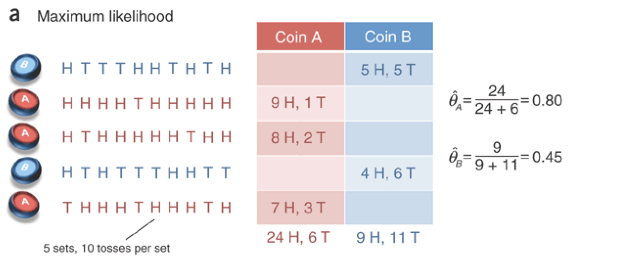

<b> https://www.nature.com/articles/nbt1406 <b>

<b> theta_a :  </b> Probability of getting heads with coin A<br>
<b> theta_a  =   </b> Number of Heads using coin A / (Number of Heads using coin A  + Number of Heads using coin B<BR>
<b> theta_b : </b> Probability of getting heads with coin B <br>
<b> theta_b  =   </b> Number of Heads using coin B / (Number of Heads using coin A  + Number of Heads using coin B<BR>

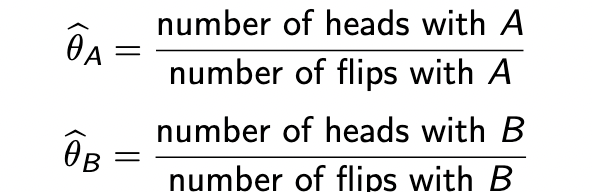

In [3]:
def Maximization(head_coin_1, tail_coin_1, head_coin_2, tail_coin_2): 
    theta_coin_1  = sum(head_coin_1)/ (sum(head_coin_1) + sum(tail_coin_1))
    theta_coin_2 =  sum(head_coin_2) / (sum(head_coin_2) + sum(tail_coin_2))
    return theta_coin_1, theta_coin_2

We will compute the likelihood using the binomial distribution

In [4]:
def likelihood(headsProb, h, t): 
    return (headsProb**h) * ((1 - headsProb)** t) 

<b> Expectation Maximization <b>

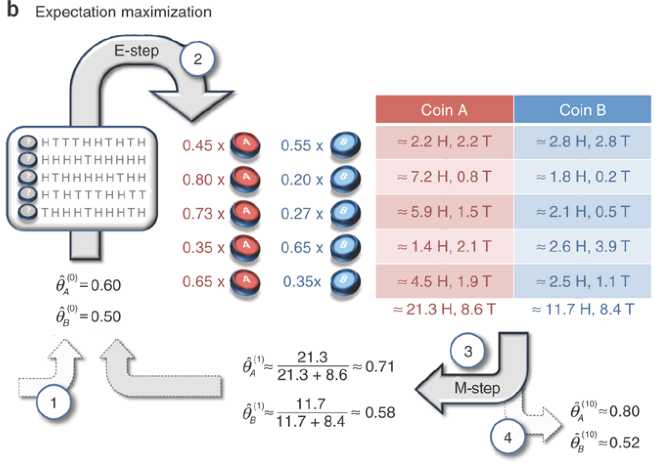

<b> https://www.nature.com/articles/nbt1406 <b>

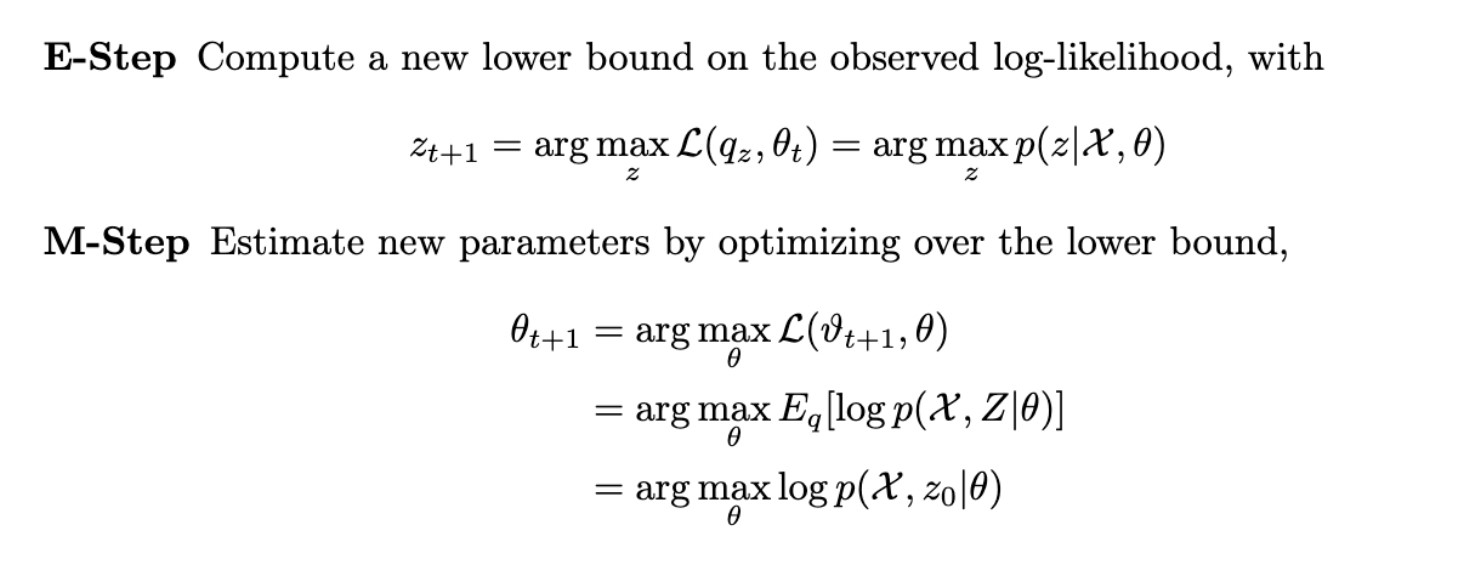

https://github.com/thejakeyboy/umich-eecs545-lectures/blob/master/lecture16_clustering-mixtures-em/eecs545_expectation-maximization-notes.pdf

- The Algorithm will stop when the last two values of theta's will be equal i.e. prev_theta_coin_1 = theta_coin_1 and prev_theta_coin_2 = theta_coin_2
- To avoid the endless while loop we have included the condition for Total Number of iterations.
- Whenever one of the condition is satisfied the algorithm will stop.

In [5]:
def Expectation_head(theta_coin_1, theta_coin_2, heads, tails): 
    coin_1_heads = np.array([0.0] * len(heads))
    coin_1_tails = np.array([0.0] * len(tails))
    coin_2_heads = np.array([0.0] * len(heads))
    coin_2_tails = np.array([0.0] * len(tails))
    thetas_coin_1,thetas_coin_2,thetas = [theta_coin_1],[theta_coin_2],[(theta_coin_1, theta_coin_2)]
    total_iteration_count = 0

    while True and total_iteration_count < 500 : 
        index = 0
        
        prev_theta_coin_1, prev_theta_coin_2 = theta_coin_1, theta_coin_2

        for i in zip(heads, tails):
            # Likelihood of Coin 1
            likelihood_coin_1 = likelihood(theta_coin_1, i[0], i[1])
            # Likelihood of Coin 2
            
            likelihood_coin_2 = likelihood(theta_coin_2, i[0], i[1])
            
            # Normalize the likelihood probability of Coin 1 
            coin_1_prob_likelihood = likelihood_coin_1 / (likelihood_coin_1 + likelihood_coin_2) 
            
            # Normalize the likelihood probability of Coin 2
            coin_2_prob_likelihood = likelihood_coin_2 / (likelihood_coin_1 + likelihood_coin_2)

            # Estimate Likely the number of heads and tails for the two coins
            coin_1_heads[index] = (coin_1_prob_likelihood*i[0])
            coin_2_heads[index] = (coin_2_prob_likelihood*i[0])
            coin_1_tails[index] = (coin_1_prob_likelihood*i[1]) 
            coin_2_tails[index] = (coin_2_prob_likelihood*i[1])
            
            index += 1

        theta_coin_1, theta_coin_2 = Maximization(coin_1_heads, coin_1_tails, coin_2_heads, coin_2_tails)
        
        thetas.append((theta_coin_1, theta_coin_2))
        
        thetas_coin_1.append(theta_coin_1)
        thetas_coin_2.append(theta_coin_2)
        
        total_iteration_count += 1
        
        # We will stop when we will get a constant value 
        #That is the previous value is eqyual to the current value for both the coins
        
        if abs(prev_theta_coin_1 ) == abs(theta_coin_1) and abs(prev_theta_coin_2) == abs(theta_coin_2) : 
            break

    return thetas, thetas_coin_1, thetas_coin_2

- Count the number of Heads and Tails

In [6]:
def count_heads_tails(json_object): 
    list_of_coins = list(map(int, list(filter(None, json.loads(json_object)['body'][1:-1].split(',')))))
    heads,tails = 0,0
    for coin in list_of_coins:
        if coin == 1:
            heads +=1
        else:
            tails +=1
    return heads, tails

In [7]:
def get_flips(number_of_draws, api_value): 
    heads, tails = list(), list()
    for i in range(number_of_draws): 
        json_object = requests.get(api_value)
        #head, tail = count_heads_tails(json_object.content)
        list_of_coins = list(map(int, list(filter(None, json.loads(json_object.content)['body'][1:-1].split(',')))))
        head,tail = 0,0
        for coin in list_of_coins:
            if coin == 1:
                head +=1
            else:
                tail +=1
        heads.append(head)
        tails.append(tail)
    return heads, tails

In [8]:
def plot_coins(theta, color, coin): 
    plt.plot(theta, color)
    plt.xlabel("Number of Iterations")
    plt.ylabel(r"$\theta_"+ str(coin)+"$")
    plt.title("Theta of coin " + str(coin))
    plt.show()

In [9]:
def log_likelihood(theta_coin_1, theta_coin_2, heads, tails):
    trials = list()
    for i in zip(heads, tails): 
        # Likelihood of Coin 1
        likelihood_coin_1 = likelihood(theta_coin_1, i[0], i[1])
        # Likelihood of Coin 2
        likelihood_coin_2 = likelihood(theta_coin_2, i[0], i[1])
        
        trials.append(np.log(0.5 * (likelihood_coin_1 + likelihood_coin_2)))
    return sum(trials)

In [10]:
def plot_likelihood(thetas, heads, tails):
    (X, Y), Z = np.meshgrid(np.linspace(0.01,0.99,100), np.linspace(0.01,0.99,100)), list()
    for i, rows in enumerate(X): 
        z = []
        for j, cols in enumerate(rows): 
            z.append(log_likelihood(cols, Y[i][j], heads, tails))
        Z.append(z)
    plt.figure(figsize = (12, 12))
    c_bar = plt.colorbar(plt.contour(X, Y, Z, 150)) 
    plt.title(r"Likelihood $\log p(\mathcal{X}|\theta_1,\theta_2)$", fontsize = 20)
    plt.xlabel(r"$\theta_1$", fontsize = 20)
    plt.ylabel(r"$\theta_2$", fontsize = 20) 
    if thetas is not None: 
        thetas = np.array(thetas)
        plt.plot(thetas[:, 0], thetas[:, 1], '-k', lw = 2.0)
        plt.plot(thetas[:, 0], thetas[:, 1], 'ok', ms = 5.0)

In [11]:
def plot_graphs(thetas_coin_1,thetas_coin_2,thetas,head,tail ):
    plot_coins(thetas_coin_1, 'g--', '1')
    plot_coins(thetas_coin_2, 'b--', '2')
    plot_likelihood(thetas, head, tail)
    

In [12]:
def expected_maximization_algorithm(): 
    head, tail = get_flips(number_of_draws = NUMBER_OF_DRAWS, api_value = API_ADDRESS)
    theta_coin_1 = INITIALIZED_THETA_COIN_1 or random.random() 
    theta_coin_2 = INITIALIZED_THETA_COIN_2 or random.random()
    thetas, thetas_coin_1, thetas_coin_2 = Expectation_head(theta_coin_1, theta_coin_2, head, tail)

    print("Iteration Number ", int(len(thetas_coin_1)), ": Theta of Coin 1 ", thetas_coin_1[-1], ", Theta of Coin 2", thetas_coin_2[-1])
    plot_graphs(thetas_coin_1,thetas_coin_2,thetas,head,tail )

Iteration Number  22 : Theta of Coin 1  0.7370483385001521 , Theta of Coin 2 0.2833720146285262


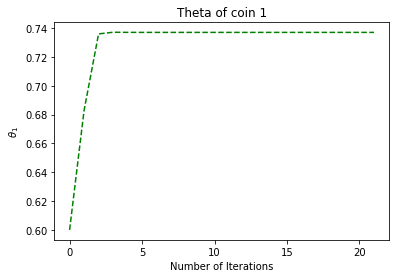

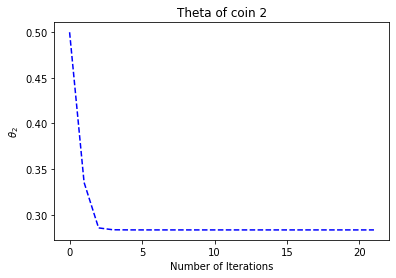

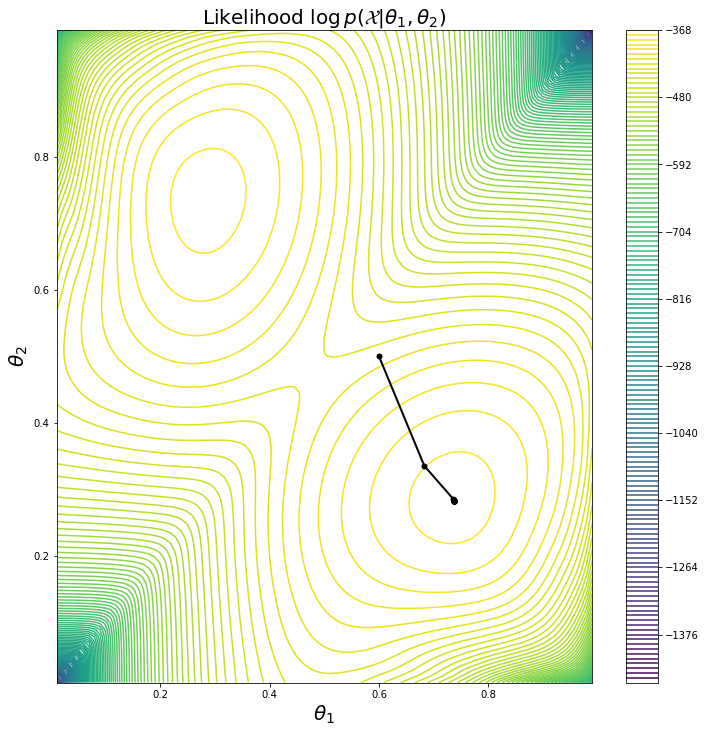

In [13]:
expected_maximization_algorithm()

<b> Source </b>

- http://karlrosaen.com/ml/notebooks/em-coin-flips/
- http://karlrosaen.com/ml/notebooks/em-coin-flips/
- https://www.youtube.com/watch?v=7e65vXZEv5Q&t=535s